---------------------------------------------------

<h1 style="text-align: center;" markdown="1">Big Data, Big Problems–Parallelizing Kmeans</h1>

-----------

<center> **Reuben McCreanor and Emily (Wei) Shao** <center>

<h3 style="text-align: center;" markdown="1">Abstract</h3>

K-means is a data-partitioning algorithm that separates n observations into k partitions. Due to its simplicity of implementation, its easy interpretability, and its ability to categorize data based on desired features, it remains one of the most popular algorithms in fields of statistics and machine learning. However, the key issue with k-means comes from its efficiency and scalability. As the size of datasets continues to increase, implementing k-means on data of any magnitude becomes computationally infeasible. A recently proposed variation of k-means, k-means++, provides a robust method of selecting the initial centers, essentially giving an optimal solution. However, due to the number of passes over the data required in a naive implementation, even clusters a million data points into 100 partitions would be exceedingly slow. In order to combat this, a parallelized version of k-means++ is proposed, k-means $||$. This version uses an over-sampling factor $\ell$ to dramatically reduce the number of passes while still arriving at an equivalent solution of partitions. This paper will implement k-means++ and k-means$||$ in both sequential and parallel setting and compare the results both in terms of efficiency and equivalency of partition arrangements.

### 1 Introduction

In general, clustering is a means of grouping observations into a set such that the other observations in this set are more similar to each other than to those in other sets. Starting with a data set, we use the use the k-means algorithm to define which observations are most similar to each other, and thus categorize these n observations into k distinct groups.

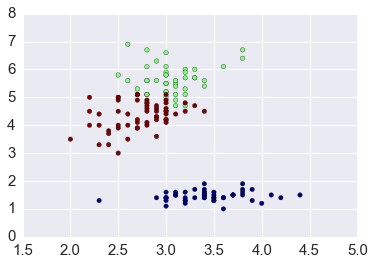

In [2]:
fig

In the example above, we can observe that data can be clustered into three partitions based on the similarity between observations. In industry, a common application of clusters is in market segmentation. Taking the example of a retailer, k-means clustering can be used as a means to understand their total addressable market. Given that their total market is comprised of people from many different incomes, locations, and type of consumers, clustering allows them to understand which groups are most similar based on these attributes and thus designing targeted marketing campaigns for each distinct group.

With these kinds of applications, k-means is both a useful and wide-reaching algorithm, however, there are two key issues with its implementation. In general, the k-means algorithm works by taking some initial centroid locations, often done by picking points at random from that data set. Each observation is then assignment the closest centroid and then the centroids are recomputed by calculating the mean of the observations assigned to it. This process is repeated until the algorithm converges, which is often measured define as none of observations changing cluster assignments within an iteration.

The key issue with this process is that the overall clustering assignment is heavily dependent on the initial centroids. Given that the k-means algorithm often gets stuck in local minima, it does not make sense to simply randomly pick the initial centroids. K-mean++ provides a solution to this problem by selecting centroids at the beginning of the process that approximate the optimal solution. 

In terms of the quality and consistency of the clustering arrangements, k-means++ is a remarkable solution. However, because the process involves looping through multiple centroid configurations in order to find the optimal one, this solution is not scalable for large data sets. To solve this problem, the k-means$||$ algorithm uses a sampling factor $\ell$ to dramatically reduce the number of passes while still arriving at an equivalent solution. The k-means$||$ algorithm is able to obtain a close to optimal solution after a logarithmic number of passes. This dramatically increases the efficiency of the algorithm and allows us to implement an optimal version of k-means clustering even of large data sets.

### 2 K-means++

#### 2.1 Overview

The k-means++ algorithm addresses the problem of suboptimal clustering arrangements by creating a procedure with which to select the inital cluster centers.  With the k-means++ initialization, we are guaranteed to find a solution that is $O(\log k)$ competitive to the optimal k-means solution.

In k-means++, the centers are first chosen uniformly at random from the observations. Then, each subsequent cluster center is chosen from the remaining data points with probability proportional to its squared distance from the point's closest existing cluster center. The intuition behind this approach is that spreading out the k initial cluster centers is a good thing, and this approach allows us to choose inital center points that are not only consistent, but approximate the optimal solution. After this point we can then proceed with the standard approach for k-means clustering.

#### 2.2 Pseudo code

Step 1: 

$\textit{C}$ $\leftarrow$ Sample a point uniformly at random from dataset X to form initial centroids;

Step 2-4: 

For j in range(k-1):
    
  a. Compute square distance: $d^2(x,C)=min||x-c_i||^2$ for $i=1,2...n$, with n=number of data points in X;

  b. Compute sampling probability for each point in X with probability= $\frac{d^2(x,C)}{\phi(X(c))}$, where $\phi(X(c))=\sum_{x\in X}d^2(x,C)$;
  
  c. Sample x $\in$ X with probability= $\frac{d^2(x,C)}{\phi(X(c))}$;
  
  d. Include x as one of the initial centroids $\textit{C}$ $\leftarrow$ $\textit{C} \cup \{x\}$ ;

Step 5: 

End loop after the initial centroids are chosen. 




#### 2.3 Implementation

In [77]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import math, random

#distance square
def dist_sq(a, b):
    '''
    calculate the distance square for array a and b
    
    Parameters
    -------
    a: np.array() with shape=[1,d]
    b: np.array() with shape=[1,d]
    
    Returns
    -------
    distance (a float number)
    '''
    return np.sum((a-b)**2)


#minimum distance square for every point to the centroid
def point_sq(data,centroid):
    
    '''
    calculate the square distance for each point in the dataset to its closest centroid
    
    Parameters
    -------
    data: np.array() with shape=[number of observations in data,d]
    centroid: np.array() with shape=[number of centroids,d]
    
    Returns
    -------
    a list of square distance for each data point in the dataset (length=number of observations)
    '''
    dist=[min(dist_sq(d,c) for c in centroid) for d in data]
    return dist
        
#calculate probability
def dist_prob_plus(Dist):
    '''
    calculate the probability for each number in the list of distances
    
    Parameters
    -------
    Dist: a list of distances
    
    Returns
    -------
    a list of probabilities with length equal to the length of original list
    '''   
    return Dist/np.sum(Dist)

def kmeansplusplus(data, k, d):
    '''
    return the initial chosen centroids for the kmeans algorithm
    
    Parameters
    -------
    data: a numpy array with shape=[number of observations, d]
    d: dimension of the data (an integer)
    k: number of clusters (an integer)
    
    Returns
    -------
    a numpy array with shape=[k,d]
    ''' 
    random.seed(22)
    #make a copy of the data
    data_copy=data.copy()
    #step 1: sample a point uniformly at random from x
    index=int(np.random.choice(data_copy.shape[0],1))
    centroid=data_copy[index]
    #once the centroid is determined, delete it from the copy 
    data_copy=np.delete(data_copy,index,axis=0)
    #step 2: while c<k, sample x from X with probability d^2/phi_x(C)
    for number in range(k-1):
        #calculate the square difference for every point in the copy to its nearest center
        distance=point_sq(data_copy,centroid)
        #calculate the probability
        prob=dist_prob_plus(distance).tolist()
        #randomly sample another centroid
        index=int(np.random.choice(data_copy.shape[0],1,prob))
        #add the new centroid
        centroid=np.vstack([centroid,data_copy[index]])
        #delete the new centroid from the copy
        data_copy=np.delete(data_copy,index,axis=0)
    return centroid

### 3 K-means$||$

#### 3.1 Overview

While k-means++ provides an approximately optimal solution, it also needs k passes over the data and thus is not scalable to large data sets. To address this problem, k-means$||$ is a parallel version for initializing the centers for the k-means clustering method. 

The k-means$||$ algorithm is intuitively similar to k-means++ except that it uses of an oversampling factor $l = \Omega(k)$, and some linear function of $k$. By instead using k-means$||$, we are able to obtain a nearly optimal solution after only a logarithmic number of passes. In  k-means$||$, we sample a point uniformly at random from our observations as an initial center and compute the cost of this clustering center. 

At each iteration, we then sample each observation in the data set with some probability, and update the given cluster set by adding the sampled points. According to the sampling probability, the expected number of points sampled in each iteration is $l$. Thus, finally the expected number of points we sampled is $l$log$\psi$, which will be greater than k. Thus, finally, we reduce the number of centers and assign weights to the points in the current cluster according to the number of observations which are closer to the given center than any other center.

#### 3.2 Pseudo code

Step 1: 

$\textit{C}$ $\leftarrow$ Sample a point uniformly at random from dataset X to form initial centroids;

Step 2: 

a. Calculate initial cost $\psi$ $\leftarrow$ $\phi(X(C))$, where $\phi(X(c))=\sum_{x\in X}d^2(x,C)$

b. Calculate number of iterations $O(log(\psi))$= int$(log(\psi))$;

Step 3-6:

a. for i in $O(log(\psi))$ interations do

b. $\textit{C'}$ sample each point x $\in$ X independently with probability $p_x=\frac{ld^2(x,C)}{\phi(x(c))}$ to form some initial centroids {C'}

c. Include {C'} as potential initial centroids to C $\textit{C}$ $\leftarrow$ $\textit{C} \cup \{C'\}$ ;

Step 7:

Calculate the weight for each potential centroid in C by counting its occurence of being chosen as the closest centroid for the entire dataset X;

Step 8:

By normalizing the weights calculated from step 7, sample k clusters from the potential centroids C with the weighted probability.



#### 3.3 Implementation

In [78]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import math

#distance square
def dist_sq(a, b):
    '''
    calculate the distance square for array a and b
    
    Parameters
    -------
    a: np.array() with shape=[1,d]
    b: np.array() with shape=[1,d]
    
    Returns
    -------
    distance (a float number)
    '''
    return np.sum((a-b)**2)


#minimum distance square for every point to the centroid
def point_sq(data,centroid):
    '''
    calculate the square distance for each point in the dataset to its closest centroid
    
    Parameters
    -------
    data: np.array() with shape=[number of observations in data,d]
    centroid: np.array() with shape=[number of centroids,d]
    
    Returns
    -------
    a list of square distance for each data point in the dataset (length=number of observations)
    '''
    
    dist=[min(dist_sq(d,c) for c in centroid) for d in data]
    return dist


#calculate probability
def dist_prob_parallel(Dist,l):
    '''
    calculate the probability for each number in the list of distances
    
    Parameters
    -------
    Dist: a list of distances
    l: oversampling factor (an integer)
    
    Returns
    -------
    a list of probabilities with length equal to the length of original list
    '''   
    return l*Dist/np.sum(Dist)


#step 2: calculate the cost and number of iterations(log(cost))
def log_cost(data_copy,centroid):
    '''
    calculate number of iteration
    
    Parameters
    -------
    data_copy: a numpy array with shape=[number of observations in data_copy, d]
    centroid: a numpy array with shape=[number of observations in centroid, d]
    
    Returns
    -------
    iteration (an integer)
    '''   
    cost=np.sum(point_sq(data_copy,centroid))
    iteration=math.ceil(np.log(cost))
    return iteration

    
#calculate weights
#step 4: assign the weights
def weight_prob(data_copy, centroid):
    '''
    calculate weights for each point in the centroid
    
    Parameters
    -------
    data_copy: a numpy array with shape=[number of observations in data_copy, d]
    centroid: a numpy array with shape=[number of observations in centroid, d]
    
    Returns
    -------
    weights (a numpy array with length=number of observations in centroid)
    ''' 
    weight=[np.argmin(list(dist_sq(d,c) for c in centroid)) for d in data_copy]
    w=np.array([weight.count(i) for i in range(len(data_copy))])
    return w



#step 5: recluster the weighted points in C into k clusters
#reinitialize k centroids
def reassign_centroids(centroid,k,d,w):
    '''
    returns the initial centroids
    
    Parameters
    -------
    centroid: a numpy array with shape=[number of observations in centroid, d]
    k=number of clusters
    d=dimension of the dataset
    w=weights calculated from the weight_prob function
    
    Returns
    -------
    new_centroids (a numpy array shape=[k,d])
    ''' 
    new_centroid=np.zeros([k,d])
    for cluster in range(k):
        #according to the weights from step 4, calculate the probability that a point is sampled from C
        prob_w=list(w/sum(w))
        #sample a new centroid
        new_index=np.random.choice(centroid.shape[0],1,prob_w)
        #store the new centroid
        new_centroid[cluster]=centroid[new_index]
        #delete the new centroid from the centroid
        centroid=np.delete(centroid,new_index,axis=0)
        #delete the correponding weight
        w=np.delete(w,new_index,axis=0)
    return new_centroid


def kmeansparallel(data, k, l, d, r):
    '''
    return the initial chosen centroids for the kmeans algorithm
    
    Parameters
    -------
    data: a numpy array with shape=[number of observations, d]
    l: oversampling facter (an integer)
    d: dimension of the data (an integer)
    k: number of clusters (an integer)
    r: number of rounds (an integer)
    
    Returns
    -------
    a numpy array with shape=[k,d]
    ''' 
    random.seed(22)
    #step 1: sample a point uniformly at random from X
    index=int(np.random.choice(data.shape[0],1))
    centroid=np.array(data[index])
    data_copy=data.copy()
    data_copy=np.delete(data_copy,index,axis=0)
    
    #step 2: calculate number of iteration
    iteration= log_cost(data_copy,centroid)
    
    #step 3: Get initial Centroids C
    for round in range(r):
        for number in range(iteration):
        #calculate phi_X(C)
            distance=point_sq(data_copy,centroid)
        #calculate the probability
            prob=dist_prob_parallel(distance,l).tolist()
            for n in range(data_copy.shape[0]):
            #if the probability is greater than the random uniform
                if prob[n]>np.random.uniform():
                #add the point to C
                    centroid=np.vstack([centroid,np.array(data_copy[n])])
                #delete that point from the copy
                    data_copy=np.delete(data_copy,n,axis=0)
    
    #step 4: calculate the weight probability
    w=weight_prob(data_copy,centroid)
    
    #step 5: recluster the weighted points in C into k clusters
    #reinitialize k centroids
    new_centroids=reassign_centroids(centroid,k,d,w)
    
    return new_centroids


### 4 K-means

Rather than simply using the existing implementation of k-means available in the sklearn package, we instead wanted to fully understand the algorithm. In order to achieve this, we also coded a version of k-means that is used to cluster the initial centers points provided from both k-means++ and k-means$||$.

In [63]:
#with the initialization of the centroids from the function kmeansplusplus
#plug in the original data(dataSet), initializtions(initial) and the dimension of the data(d)
def kmeans(dataSet, initial, k, d):
    '''
    return the final centroids and a label for each point in the dataset
    
    Parameters
    -------
    dataSet: a numpy array with shape=[number of observations, d]
    initial: initial centroids chosen from kmeans++ or kmeans|| with shape=[k,d]
    d: dimension of the data (an integer)
    k: number of clusters (an integer)
    
    Returns
    -------
    final centroids with shape=[k,d]
    labels[integers]: a numpy array with length=number of intergers
    ''' 
    random.seed(22)
    centroids=initial
    # Initialize book keeping vars.
    iterations = 0
    oldCentroids = np.zeros(initial.shape)
    
    # Run the main k-means algorithm
    while not shouldStop(oldCentroids, centroids, iterations):
        # Save old centroids for convergence test. Book keeping.
        oldCentroids = centroids
        iterations += 1
        
        # Assign labels to each datapoint based on centroids
        l= getLabels(dataSet, centroids)
        
        # Assign centroids based on datapoint labels
        centroids = getCentroids(dataSet, l, k, d)
        
    # We can get the labels too by calling getLabels(dataSet, centroids)
    return centroids, np.array(l)
# Function: Should Stop
# -------------
# Returns True or False if k-means is done. K-means terminates either
# because it has run a maximum number of iterations OR the centroids
# stop changing.
def shouldStop(oldCentroids, centroids, iterations):
    '''
    return True or False
    
    Parameters
    -------
    oldCentroids: a numpy array with shape=[k, d]
    centroids: a numpy array with shape=[k, d]
    iterations: an integer
    
    Returns
    -------
    True or False
    ''' 
    
    if iterations > 50: return True
    return oldCentroids.all == centroids.all
# Function: Get Labels
# -------------
# Returns a label for each piece of data in the dataset. 
def getLabels(dataSet, centroids):
    # For each element in the dataset, chose the closest centroid. 
    # Make that centroid the element's label.
    '''
    return a list of labels
    
    Parameters
    -------
    dataSet: a numpy array with shape=[number of observations in the dataSet, d]
    centroids: a numpy array with shape=[k, d]
    
    Returns
    -------
    a list of labels with length=number of observations in the dataSet
    ''' 
    l=[np.argmin(list(dist_sq(d,c) for c in centroids)) for d in dataSet]
    return l
# Function: Get Centroids
# -------------
# Returns k random centroids, each of dimension n.
def getCentroids(dataSet, labels, k, d):
    '''
    return a numpy array with shape=[k,d]
    
    Parameters
    -------
    dataSet: a numpy array with shape=[number of observations in the dataSet, d]
    labels: a list of labels with length=number of observations in dataSet
    k=number of clusters
    d=dimension of dataSet
    Returns
    -------
    centroids (a numpy array with shape=[k,d])
    ''' 
    
    # Each centroid is the arithmetic mean of the points that
    # have that centroid's label.
    data_new = DataFrame(dataSet.copy())
    data_new['Labels'] = labels
    data_new = np.array(data_new.groupby(['Labels']).mean().iloc[:,:d])
  
    return data_new


### 5 Testing

#### 5.1 Functions Testing

a. test_distance_sq: testing if the distance is non-negative, testing the coincidences when the distance is zero and nonzero, testing if the function returns correct values given valid inputs.

b. test_point_sq: testing if the square distance is non-negative, testing the coincidences when the square distance is zero and nonzero, testing if the function returns correct values given valid inputs

c. test_dist_prob_plus_parallel: testing if the probabilities sum to 1 and is non-negative for both k-means++ and k-means$||$

d. test_log_cost: testing if the number of iterations is positive

e. test_kmeansplusplus_parallel: testing if both k-means++ and k-means$||$ returns k centroids

f. test_weights: testing if all weights are non-negative

g. test_reassign_centroids: testing if the function reduces potential centroids to k centroids.

h. test_kmeans: testing if k-means returns k clusters

i.   test_shouldStop: testing the stopping rules when (1) number of iterations is greater than 50; (2) the old and new centroids are not equal; (3) the old and new centroids are equal.

j. test_getLabels: testing if number of unique labels the data points are assigned to is no greater than k

k.  test_getCentroids: testing if the number of centroids generated is no greater than k

**5.2 Testing Code**

In [79]:
%%file test_distance_sq.py
import numpy as np
import kmeans_combined
from numpy.testing import assert_almost_equal
from kmeans_combined import dist_sq

def test_non_negativity():
    for i in range(10):
        u = np.random.normal(3)
        v = np.random.normal(3)
        assert dist_sq(u, v) >= 0

def test_coincidence_when_zero():
    u = np.zeros(3)
    v = np.zeros(3)
    assert dist_sq(u, v) == 0

def test_coincidence_when_not_zero():
     for i in range(10):
        u = np.random.random(3)
        v = np.zeros(3)
        assert dist_sq(u, v) != 0

def test_symmetry():
    for i in range(10):
        u = np.random.random(3)
        v = np.random.random(3)
        assert dist_sq(u, v) == dist_sq(v, u)

def test_known1():
    u = np.array([0])
    v = np.array([3])
    assert_almost_equal(dist_sq(u, v), 9)

def test_known2():
    u = np.array([0,0])
    v = np.array([3, 4])
    assert_almost_equal(dist_sq(u, v), 25)

def test_known3():
    u = np.array([0,0])
    v = np.array([-3, -4])
    assert_almost_equal(dist_sq(u, v), 25)

Overwriting test_distance_sq.py


In [80]:
%%file test_point_sq.py
import kmeans_combined
from kmeans_combined import point_sq
import numpy as np
from numpy.testing import assert_almost_equal


def test_non_negativity_p():
    for i in range(10):
        data = np.random.normal(size=(10,15))
        c = data[np.random.choice(range(10),5)]
        assert (all(point_sq(data, c)) >= 0)

def test_coincidence_when_zero_p():
    for i in range(10):
        data = np.random.normal(size=(10,15))
        c = data
        assert (all(point_sq(data,c)) == 0)

def test_more_centers_less_point_sq():
    for i in range(10):
        data = np.random.normal(size=(10,15))
        c_more = data[np.random.choice(range(5),4),]
        c=c_more[:3]
        assert (all(point_sq(c_more, data)) <= all(point_sq(c, data)))

Overwriting test_point_sq.py


In [81]:
%%file test_dist_prob_plus_parallel.py
import kmeans_combined
from kmeans_combined import dist_prob_plus, dist_prob_parallel
import numpy as np
from numpy.testing import assert_almost_equal

def test_prob_sum_to_1():
    for i in range(10):
        data=np.random.random(size=10).tolist()
        l=4
        assert_almost_equal(sum(dist_prob_plus(data)),1) and assert_almost_equal(sum(dist_prob_parallel(data,l)),1)

def test_all_positive():
    for i in range(10):
        data=np.random.random(size=10).tolist()
        l=4
        assert all(dist_prob_plus(data))>=0 and all(dist_prob_parallel(data,l))>=0



Overwriting test_dist_prob_plus_parallel.py


In [82]:
%%file test_log_cost.py
import numpy as np
import kmeans_combined
from kmeans_combined import log_cost
def test_all_positive_log_cost():
    for i in range(10):
        data = np.random.normal(size=(10,15))
        c = data[np.random.choice(range(10),5)]
        assert log_cost(data, c)>0

    

Overwriting test_log_cost.py


In [83]:
%%file test_kmeansplusplus_parallel.py
import kmeans_combined
from kmeans_combined import kmeansplusplus, kmeansparallel
import numpy as np
from numpy.testing import assert_almost_equal

def test_samplesize_is_k():
    for i in range(10):
        data = np.random.normal(size=(10000,15))
        k=5
        d=15
        l=10
        r=1
        assert_almost_equal(kmeansplusplus(data, k, d).shape[0], k) and assert_almost_equal(kmeansparallel(data, k,l,d,r).shape[0], k)

        

Overwriting test_kmeansplusplus_parallel.py


In [84]:
%%file test_weights.py
import numpy as np
import kmeans_combined
from kmeans_combined import weight_prob

def test_all_positive_weights():
    for i in range(10):
        data = np.random.normal(size=(10,15))
        c = data[np.random.choice(range(10),5)]
        assert all(weight_prob(data, c))>=0


Overwriting test_weights.py


In [85]:
%%file test_reassign_centroids.py
import numpy as np
import kmeans_combined
from kmeans_combined import reassign_centroids, weight_prob

def test_more_given_centroids_than_reassigned():
    for i in range(10):
        data = np.random.normal(size=(1000,15))
        c = data[np.random.choice(range(10),15)]
        w=weight_prob(data,c)
        assert reassign_centroids(c,5,15,w).shape[0]<c.shape[0]

Overwriting test_reassign_centroids.py


In [86]:
%%file test_kmeans.py
import numpy as np
import kmeans_combined
from kmeans_combined import kmeans, kmeansparallel

def test_kmeans_shape():
    for i in range(10):
        data = np.random.normal(size=(1000,15))
        k=5
        d=15
        l=10
        r=1
        initial=kmeansparallel(data,k,l,d,r)
        assert len(np.unique(kmeans(data,initial,k,d)[1]))==k


Overwriting test_kmeans.py


In [87]:
%%file test_shouldStop.py
import numpy as np
import kmeans_combined
from kmeans_combined import shouldStop

def test_shouldStop_iteration_greater_than_50():
    for i in range(10):
        old = np.random.normal(size=(10,15))
        new = np.random.normal(size=(10,15))
        iteration=60
        assert shouldStop(old, new, iteration)==True

def test_shouldStop_old_new_not_equal():
    for i in range(10):
        old = np.random.normal(size=(10,15))
        new = np.random.normal(size=(10,15))
        iteration=30
        assert shouldStop(old, new, iteration)==False

def test_shouldStop_old_new_equal():
    for i in range(10):
        old = np.random.normal(size=(10,15))
        new = old
        iteration=30
        assert shouldStop(old, new, iteration)==True


Overwriting test_shouldStop.py


In [88]:
%%file test_getLabels.py
import numpy as np
import kmeans_combined
from kmeans_combined import getLabels

def test_getLables_labels_no_greater_than_k():
    for i in range(10):
        data = np.random.normal(size=(10,15))
        c = data[np.random.choice(range(10),5)]
        k=5
        assert len(np.unique(getLabels(data,c)))<=k and len(np.unique(getLabels(data,c)))>0



Overwriting test_getLabels.py


In [89]:
%%file test_getCentroids.py
import numpy as np
import kmeans_combined
from kmeans_combined import getCentroids

def test_getCentroids_when_labels_less_than_k():
    for i in range(10):
        data = np.random.normal(size=(1000,15))
        c = data[np.random.choice(range(1000),10)]
        k=10
        d=15
        labels=np.random.choice(range(7),1000)
        assert getCentroids(data, labels, k, d).shape[0]<=k


Overwriting test_getCentroids.py


In [90]:
! py.test

============================= test session starts ==============================
platform darwin -- Python 3.5.1, pytest-2.8.1, py-1.4.30, pluggy-0.3.1
rootdir: /Users/wsswemily/Desktop/Sta663_Final_Project, inifile: 
collected 22 items 

test_dist_prob_plus_parallel.py ..
test_distance_sq.py .......
test_getCentroids.py .
test_getLabels.py .
test_kmeans.py .
test_kmeansplusplus_parallel.py .
test_log_cost.py .
test_point_sq.py ...
test_reassign_centroids.py .
test_shouldStop.py ...
test_weights.py .

========================== 22 passed in 65.51 seconds ==========================


### 6 Optimization

#### 6.1 Improving Python

Once our code was working and tested the first step was to simply improve the Python implementation. In order to do this we turned many of our loops into list comprehension and Numpy functions to improve the efficiency of our code. 

#### 6.2  Numba and Cython

Our first approach at optimization involves using a just in time compilation with Numba. Essentially, a JIT compiler runs after the program has started and compiles the code using some type of bytecode as it is needed, thus giving us a faster form. With our Numba implementation we manage improvements over both k-means++ and our pure Python version of k-means. 

We also implement a Cython version of our code for comparison. As many of our functions involve large data frames that are difficult to implement in C, our Cython version improved on the pure Python implementation, however was not as fast as Numba. The results generated with Cython can be seen in suppFunctions/kmeansCython.

From this point we therefore took Numba as our fastest implementation thus far, and attempted a parallelized version in order to achieve further improvements in our optimization. 

#### 6.3 Parallelization

As k-means is often talked about as an embarrassingly parallelizable algorithm--meaning that the clustering can be worked on in different partitions at the same time--there are large gains in optimization to be made. The authors Bahmani et al. recommend that for 6 clusters, the optimal number of machines m is defined by $m =\sqrt{\frac{n}{k}}$, this would be that in our case we should ideally be using 40 partitions. While we do not have anything close this amount of resources, there are still significant gains to be made, even in a local parallelization on a 4 core machine.

In order to parallelize our implementation of k-means$||$, we first try a multicore approach. While this yields some gains, it is not as effective as we would like due to the fact that only some of our functions lend themselves to an MC implementation.

Instead, we are able to significantly improve on this by using an ipyparallel approach with 4 cores. In doing this we achieve a total run time of 22 seconds. This is faster than both the k-means++ and the any other optimized implementation of k-means$||$. This and all of the other run times can be seen in Results.ipynb.

#### 6.4 Comparsions of Efficiency

Overall, we find that the parallelization of k-means$||$ yields the best results. This is to be expected for as stated by Bahman et al., “k-means$||$ running time improves linearly with the number of available machines. ” As we see from the timing of our different implementation across Python, Numba, Cython, and Ipyparallel, our implementation in Ipyparallel provided a good speed up of the k-means$||$ algorithm. As we will also see in section (8) below, our parallel implementation also provides good clustering results on both simulated and real world data when we test it on data sets of 10,000 observations and 144,029 observations respectively.

A further extension to this parallelization would be to implement k-means$||$ in a map reduce implementation within a Spark environment. Given the linear increase in running time, it is to be expected that this type of implementation would yield even greater increases in efficiency. In practice, this would mean that the k-means algorithm could be implemented on datasets with millions of observations. This is important because it truly makes one of the most widely used clustering methods scalable to problems involving big data. 

#### 6.5 Code

Due to the length of the code, we only include the version using ipyparallel below as this gave our the optimal solution. Further results from the other optimization methods can be seen in Results.ipynb.

In [39]:
from ipyparallel import Client

In [40]:
rc = Client()
dv = rc[:]

/Users/wsswemily/anaconda/lib/python3.5/site-packages/ipyparallel/client/client.py:436: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@10.190.96.32')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


In [73]:
with dv.sync_imports():
    import numba, math
    import numpy as np
    import pandas as pd
    import random

@numba.jit

#distance square
def dist_sq_py(a, b):
    '''
    calculate the distance square for array a and b
    
    Parameters
    -------
    a: np.array() with shape=[1,d]
    b: np.array() with shape=[1,d]
    
    Returns
    -------
    distance (a float number)
    '''
    return np.sum((a-b)**2)

#minimum distance square for every point to the centroid
def point_sq_py(data,centroid):
    '''
    calculate the square distance for each point in the dataset to its closest centroid
    
    Parameters
    -------
    data: np.array() with shape=[number of observations in data,d]
    centroid: np.array() with shape=[number of centroids,d]
    
    Returns
    -------
    a list of square distance for each data point in the dataset (length=number of observations)
    '''
    dist=[min(dist_sq_py(d,c) for c in centroid) for d in data]
    return dist
        

#calculate probability
def dist_prob_parallel_py(Dist,l):
    '''
    calculate the probability for each number in the list of distances
    
    Parameters
    -------
    Dist: a list of distances
    l: oversampling factor (an integer)
    
    Returns
    -------
    a list of probabilities with length equal to the length of original list
    '''   
    return l*Dist/np.sum(Dist)



#step 2: calculate the cost and number of iterations(log(cost))
def log_cost_py(data_copy,centroid):
    '''
    calculate number of iteration
    
    Parameters
    -------
    data_copy: a numpy array with shape=[number of observations in data_copy, d]
    centroid: a numpy array with shape=[number of observations in centroid, d]
    
    Returns
    -------
    iteration (an integer)
    '''   
    cost=np.sum(point_sq_py(data_copy,centroid))
    iteration=math.ceil(np.log(cost))
    return iteration

    
    
#calculate weights
#step 4: assign the weights
#calculate weights
#step 4: assign the weights
def weight_prob_py(data_copy, centroid):
    '''
    calculate weights for each point in the centroid
    
    Parameters
    -------
    data_copy: a numpy array with shape=[number of observations in data_copy, d]
    centroid: a numpy array with shape=[number of observations in centroid, d]
    
    Returns
    -------
    weights (a numpy array with length=number of observations in centroid)
    ''' 
    weight=[np.argmin(list(dist_sq_py(d,c) for c in centroid)) for d in data_copy]
    w=np.array([weight.count(i) for i in range(len(data_copy))])
    return w



#step 5: recluster the weighted points in C into k clusters
#reinitialize k centroids
def reassign_centroids_py(centroid,k,d,w):
    '''
    returns the initial centroids
    
    Parameters
    -------
    centroid: a numpy array with shape=[number of observations in centroid, d]
    k=number of clusters
    d=dimension of the dataset
    w=weights calculated from the weight_prob function
    
    Returns
    -------
    new_centroids (a numpy array shape=[k,d])
    ''' 
    new_centroid=np.zeros([k,d])
    for cluster in range(k):
        #according to the weights from step 4, calculate the probability that a point is sampled from C
        prob_w=list(w/sum(w))
        #sample a new centroid
        new_index=np.random.choice(centroid.shape[0],1,prob_w)
        #store the new centroid
        new_centroid[cluster]=centroid[new_index]
        #delete the new centroid from the centroid
        centroid=np.delete(centroid,new_index,axis=0)
        #delete the correponding weight
        w=np.delete(w,new_index,axis=0)
    return new_centroid



def kmeansparallel_py(data, k, l, d, r):
    '''
    return the initial chosen centroids for the kmeans algorithm
    
    Parameters
    -------
    data: a numpy array with shape=[number of observations, d]
    l: oversampling facter (an integer)
    d: dimension of the data (an integer)
    k: number of clusters (an integer)
    r: number of rounds (an integer)
    
    Returns
    -------
    a numpy array with shape=[k,d]
    ''' 
    random.seed(22)
    #step 1: sample a point uniformly at random from X
    index=int(np.random.choice(data.shape[0],1))
    centroid=np.array(data[index])
    data_copy=data.copy()
    data_copy=np.delete(data_copy,index,axis=0)
    
    #step 2: calculate number of iteration
    iteration= log_cost_py(data_copy,centroid)
    
    #step 3: Get initial Centroids C
    for round in range(r):
        for number in range(iteration):
        #calculate phi_X(C)
            distance=point_sq_py(data_copy,centroid)
        #calculate the probability
            prob=dist_prob_parallel_py(distance,l).tolist()
            for n in range(data_copy.shape[0]):
            #if the probability is greater than the random uniform
                if prob[n]>np.random.uniform():
                #add the point to C
                    centroid=np.vstack([centroid,np.array(data_copy[n])])
                #delete that point from the copy
                    data_copy=np.delete(data_copy,n,axis=0)
    
    #step 4: calculate the weight probability
    w=weight_prob_py(data_copy,centroid)
    
    #step 5: recluster the weighted points in C into k clusters
    #reinitialize k centroids
    new_centroids=reassign_centroids_py(centroid,k,d,w)
    
    return new_centroids

    
#with the initialization of the centroids from the function kmeansplusplus
#plug in the original data(dataSet), initializtions(initial) and the dimension of the data(d)
def kmeans_py(dataSet, initial, k, d):
    '''
    return the final centroids and a label for each point in the dataset
    
    Parameters
    -------
    dataSet: a numpy array with shape=[number of observations, d]
    initial: initial centroids chosen from kmeans++ or kmeans|| with shape=[k,d]
    d: dimension of the data (an integer)
    k: number of clusters (an integer)
    
    Returns
    -------
    final centroids with shape=[k,d]
    labels[integers]: a numpy array with length=number of intergers
    ''' 
    random.seed(22)
    centroids=initial
    # Initialize book keeping vars.
    iterations = 0
    oldCentroids = np.zeros(initial.shape)
    
    # Run the main k-means algorithm
    while not shouldStop_py(oldCentroids, centroids, iterations):
        # Save old centroids for convergence test. Book keeping.
        oldCentroids = centroids
        iterations += 1
        
        # Assign labels to each datapoint based on centroids
        l= getLabels_py(dataSet, centroids)
        
        # Assign centroids based on datapoint labels
        centroids = getCentroids_py(dataSet, l, k, d)
        
    # We can get the labels too by calling getLabels(dataSet, centroids)
    return centroids, np.array(l)
# Function: Should Stop
# -------------
# Returns True or False if k-means is done. K-means terminates either
# because it has run a maximum number of iterations OR the centroids
# stop changing.
def shouldStop_py(oldCentroids, centroids, iterations):
    '''
    return True or False
    
    Parameters
    -------
    oldCentroids: a numpy array with shape=[k, d]
    centroids: a numpy array with shape=[k, d]
    iterations: an integer
    
    Returns
    -------
    True or False
    ''' 
    if iterations > 50: return True
    return oldCentroids.all == centroids.all
# Function: Get Labels
# -------------
# Returns a label for each piece of data in the dataset. 
def getLabels_py(dataSet, centroids):
    # For each element in the dataset, chose the closest centroid. 
    # Make that centroid the element's label.
    '''
    return a list of labels
    
    Parameters
    -------
    dataSet: a numpy array with shape=[number of observations in the dataSet, d]
    centroids: a numpy array with shape=[k, d]
    
    Returns
    -------
    a list of labels with length=number of observations in the dataSet
    ''' 
    l=[np.argmin(list(dist_sq_py(d,c) for c in centroids)) for d in dataSet]
    return l
# Function: Get Centroids
# -------------
# Returns k random centroids, each of dimension n.
def getCentroids_py(dataSet, labels, k, d):
    '''
    return a numpy array with shape=[k,d]
    
    Parameters
    -------
    dataSet: a numpy array with shape=[number of observations in the dataSet, d]
    labels: a list of labels with length=number of observations in dataSet
    k=number of clusters
    d=dimension of dataSet
    Returns
    -------
    centroids (a numpy array with shape=[k,d])
    ''' 
    # Each centroid is the arithmetic mean of the points that
    # have that centroid's label.
    data_new = pd.DataFrame(dataSet.copy())
    data_new['Labels'] = labels
    data_new = np.array(data_new.groupby(['Labels']).mean().iloc[:,:d])
  
    return data_new

importing numba on engine(s)
importing math on engine(s)
importing numpy on engine(s)
importing pandas on engine(s)
importing random on engine(s)


### 7 Data

#### 7.1 Data simulation

To generate the dataset,
we sampled k centers from a 15-dimensional spherical Gaussian
distribution with mean at the origin and variance R ∈
{1, 10, 100}. We then added points from Gaussian distributions
of unit variance around each center. Given the k centers,
this is a mixture of k spherical Gaussians with equal
weights. Note that the Gaussians are separated in terms
of probability mass — even if only marginally for the case
R = 1 — and therefore the value of the optimal k-clustering
can be well approximated using the centers of these Gaussians.
The number of sampled points from this mixture of
Gaussians is n = 10, 000.

In [55]:
import numpy as np
def generate_centers(k, var, dim):
    """Generate k centers from 15-dimensional spherical Gaussian distribution with the given variance"""
    random.seed(22)
    centers = np.random.multivariate_normal(np.zeros(dim),  np.eye(dim)*var, k)
    return centers

def generate_data(k, var, dim, npoints):
    """Generate data points around each center such that there are 10,000 data points total including the centers?
    This could also be 10000 data points total plus the centers if this is better? Just chance the -k in 
    the sampData line"""
    random.seed(22)
    # generate centers
    centers = generate_centers(k, var, dim)
    # array to store points #
    points = np.empty([1,dim])
    # generate data around each center
    for i in range(k):
        points = np.concatenate((points, np.random.multivariate_normal(centers[i],np.eye(dim),npoints)), axis=0)
        points = np.delete(points, 0, axis=0)
    # sample points from array and combine these with centers
    sampData = np.concatenate((centers, points[np.random.choice(len(points),npoints-k)]), axis = 0)
    return(sampData)

**simulated data to test time**

In [44]:
random.seed(22)
sim_data = generate_data(k=6,var=100,dim=15, npoints=10000)

**simulated data for clustering**

In [56]:
random.seed(22)
sim_data_k6 = generate_data(k=6, var=100, dim=2, npoints=10000)

#### 7.2 Real world data

Based on our previous work with geocoding, we implement the k-mean clustering algorithm on a subsection of our data set, NYCBoroughs.csv. This data contains latitude and longitude coordinates from individual tax fillings from three boroughs of New York City: Bronx, Brooklyn, and Staten Island. In total this dataset includes 144,029 total observations making it a good candidate for testing our algorithm on a real world dataset. The three boroughs are geographically dispersed and we therefore set the number of clusters equal to three in the hope that our results will categorize each coordinate point to correct borough.

In [88]:
real_data=pd.read_csv('NYBoroughs.csv')

In [89]:
real_data.drop(real_data.columns[[0,1]], axis=1, inplace=True)

In [90]:
real_data=np.array(real_data)
d=real_data.shape[1]
n=real_data.shape[0]
k=3

In [91]:
#scale the magnitude of the real data
real_data=real_data/100000

### 8 Results

All the code to generate the results are contained in /suppFunctions. Specifically, the results generated from all the algorithms are contained in /suppFunctions/Results.ipynb. The following results are shown as examples.

#### A. Simulated Data

In [50]:
#parameters for all below algorithms
k = 6
l=k*2
d = 2
r = 1

**Kmeans++ clustering**

In [64]:
random.seed(22)
sim_plus = kmeans(sim_data_k6, kmeansplusplus(sim_data_k6, k, d), k, d)

In [65]:
#subset x values and y values for plotting
x_plus = sim_plus[0][:,0]
y_plus = sim_plus[0][:,1]
labels_plus = sim_plus[1]

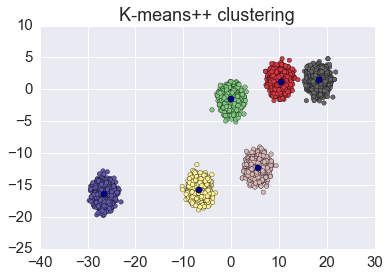

In [66]:
plt.figure()
plt.scatter(sim_data_k6[:,0], sim_data_k6[:,1], c=labels_plus, cmap='Accent')
plt.scatter(x_plus, y_plus, s=40, marker="o", c="darkblue")
plt.title("K-means++ clustering")
pass

**Kmeans$||$ clustering**

In [67]:
random.seed(22)
sim_para = kmeans(sim_data_k6,kmeansparallel(sim_data_k6, k, l, d, r),k,d)

In [68]:
x_para = sim_para[0][:,0]
y_para = sim_para[0][:,1]
labels_para = sim_para[1]

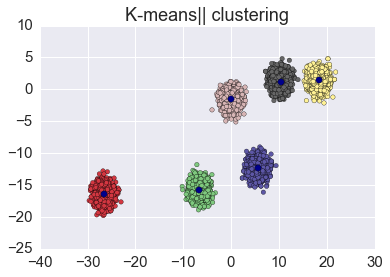

In [69]:
plt.figure()
plt.scatter(sim_data_k6[:,0], sim_data_k6[:,1], c=labels_para, cmap='Accent')
plt.scatter(x_para, y_para, s=40, marker="o", c="darkblue")
plt.title("K-means|| clustering")
pass

**Kmeans$||$ with ipyparallel**

In [74]:
random.seed(22)
sim_ipy = kmeans_py(sim_data_k6,kmeansparallel_py(sim_data_k6, k, l, d, r),k,d)

In [75]:
x_ipy = sim_ipy[0][:,0]
y_ipy = sim_ipy[0][:,1]
labels_ipy = sim_ipy[1]

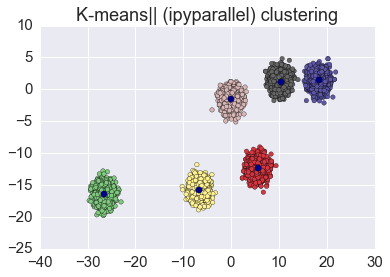

In [76]:
plt.figure()
plt.scatter(sim_data_k6[:,0], sim_data_k6[:,1], c=labels_ipy, cmap='Accent')
plt.scatter(x_ipy, y_ipy, s=40, marker="o", c="darkblue")
plt.title("K-means|| (ipyparallel) clustering")
pass

As we can see from the results above, the implementation of k-means++ and both the optimized and original implementation of k-means$||$ provide great clustering results on this sample data set.

#### A. Real Data

**Kmeans++**

In [92]:
k=3
res_plus = kmeans(real_data,kmeansplusplus(real_data,k,d),k, d)

In [93]:
res_x_plus = res_plus[0][:,0]
res_y_plus = res_plus[0][:,1]
res_labels_plus = res_plus[1]

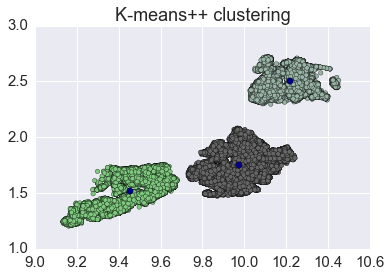

In [94]:
plt.figure()
plt.scatter(real_data[:,0], real_data[:,1], c=res_labels_plus, cmap='Accent')
plt.scatter(res_x_plus, res_y_plus, s=40, marker="o", c="darkblue")
plt.title("K-means++ clustering")
pass

**Kmeans$||$**

In [95]:
#kmeans||parameters
l=6
r=1

In [96]:
k=3
res_para = kmeans(real_data,kmeansparallel(real_data, k, l, d, r),k,d)

In [97]:
res_x_para = res_para[0][:,0]
res_y_para = res_para[0][:,1]
res_labels_para = res_para[1]

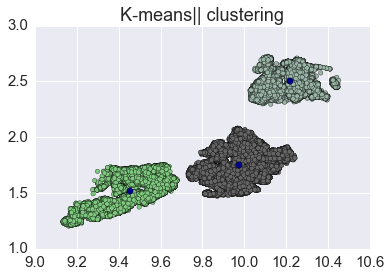

In [98]:
plt.figure()
plt.scatter(real_data[:,0], real_data[:,1], c=res_labels_para, cmap='Accent')
plt.scatter(res_x_para, res_y_para, s=40, marker="o", c="darkblue")
plt.title("K-means|| clustering")
pass

**Kmeans$||$ with ipyparallel**

In [99]:
k=3
res_ipy = kmeans_py(real_data,kmeansparallel_py(real_data, k, l, d, r),k,d)

In [100]:
res_x_ipy = res_ipy[0][:,0]
res_y_ipy = res_ipy[0][:,1]
labels_res_ipy = res_ipy[1]

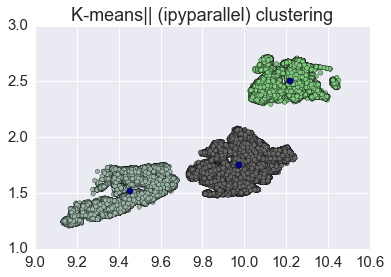

In [101]:
plt.figure()
plt.scatter(real_data[:,0], real_data[:,1], c=labels_res_ipy, cmap='Accent')
plt.scatter(res_x_ipy, res_y_ipy, s=40, marker="o", c="darkblue")
plt.title("K-means|| (ipyparallel) clustering")
pass

**Timing**

All the timing results are contained in Results.ipynb with the simulated data.

### 9 Conclusions

While k-means is a widely used algorithm, its issues in scalability and efficiency make it computationally infeasible to run on large data sets. Further, due to the often random selection of initial points, k-means can have different results with every iteration making it inherently unstable. K-means++ addresses this issue by providing an optimal means of selecting the initial centers. However, due to the number of passes required in this selection, it only makes things worse in terms of both scalability and efficiency.

In order to address this problem, k-means$||$ provides a scalable solution that linearly increases in efficiency with increases in computing power. k-means$||$ uses of an oversampling factor $l = \Omega(k)$ to select more than k potential centroids with an initial iteration of $log(\psi)$. This algorithm then reduces the number potential centroids to k by sampling each centroid with the probability proportional to it being chosen as the closest centroid for other points in the dataset. With this approach the k-means$||$ can increase the efficiency of selecting initial centroids compared to k-means++. 


The results in section (8) show that k-means++ and k-means$||$ provide the similar optimal clustering results. The points that are labeled with the same color can be determined as in the same cluster.

For the reasons that k-means$||$ algorithm initiates a centroid by sampling it from the entire dataset and searches for the potential centroids by looping throughout the dataset, more improvements can be further done in order to optimize the efficiency. For example, the initialized point could be first determined as the central mass point of a sphere given a dataset with three dimensions. Rather than randomly initializing a centroid, we could choose the central mass point as the initialized centroid, as it is more likely chosen as a potential centroid. And finally we could apply the kmeans$||$ algorithm with this initialized centroid.

### Appendix I

#### Code for visualizations

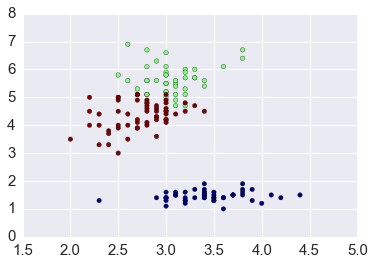

In [1]:
from sklearn import cluster
from matplotlib import pyplot
import numpy as np

# load iris data and exclude species column
iris = sns.load_dataset("iris").ix[:, 0:3]
# set number of clusters #
k = 3
kmeans = cluster.KMeans(n_clusters=k)
kmeans.fit(iris)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
from matplotlib import pyplot
import numpy as np

from matplotlib import pyplot
import numpy as np
plt.scatter(iris.ix[:,1], iris.ix[:,2], c=labels, cmap='jet')
fig = plt.gcf()